<div class="alert alert-block alert-success">
This jupyter notebook is part of the supplementary material for the book "Materials Data Science" (Stefan Sandfeld, Springer, 2024, DOI 10.1007/978-3-031-46565-9). For further details please refer to the accompanying webpage at <a href="https://mds-book.org">https://mds-book.org</a>.
</div>

In [93]:
import matplotlib.pyplot as plt
import numpy as np


# Copied from listing 12.1
def train_test_split(X, Y, fraction, seed=None):
    """
        Returns a training and a testing dataset (Python Listing 12.1)
        X and Y are numpy arrays with as many rows as samples, fraction (=0..1) defines
        the relative amount of training data, and seed is the initialization of the
        random number generator.
    """


    rng = np.random.default_rng(seed)         # initialize random number generator
    n_total_data = X.shape[0]                 # number of data in the full DS
    n_training = int(fraction * n_total_data) # use fraction of data for training

    indices = np.arange(n_total_data)         # range of integers for indexing X and Y
    
    rng.shuffle(indices)                      # shuffle elements of "indices" in place
    X = X[indices]                            # X and y are shuffled such that each X[i]
    Y = Y[indices]                            # ... is still associated with the same Y[i]

    X_training = X[:n_training]               # use the first "n_training" points for the
    Y_training = Y[:n_training]               # training dataset and ...
    X_testing = X[n_training:]                # the rest of the data for testing.
    Y_testing = Y[n_training:]
    
    return X_training, Y_training, X_testing, Y_testing

## 18.5 Python Implementation and Example for the Fully Connected Network
### 18.5.1 Python Implementation
A step-by-step explanation is given in section 18.5.1 of the MDS book.

We start by creating an abstract base class from which both the activation layer and the fully connected layer are derived:

In [94]:
from abc import ABC
import numpy as np

# For implementing an abstract base class (ABC)
class NNLayer(ABC):
    def __init__(self):
        self.x = np.empty()
        self.y = np.empty()

    def feed_forward(self, x):
        raise NotImplementedError("Any layer needs to implement the feed_forward method.")
    
    def backward_propagation(self, dJdy, learning_rate):
        raise NotImplementedError("Any layer needs to implement the backward_propagation method.")

Next, implement the class `FullyConnectedLayer` which is derived from `NNLayer`, guaranteeing that all layer types always have the same structure:

In [95]:
class FullyConnectedLayer(NNLayer):
    def __init__(self, n_inputs, n_outputs, seed=None):
        rng = np.random.default_rng(seed)
        self.weights = rng.random(size=(n_inputs, n_outputs)) - 0.5
        self.biases = rng.random(size=(1, n_outputs)) - 0.5

    def feed_forward(self, x):
        self.x = np.atleast_2d(x)
        self.y = np.dot(self.x, self.weights) + self.biases
        return self.y

    def backward_propagation(self, dJdy, learning_rate):
        dJdW = np.dot(self.x.T, dJdy)
        dJdb = np.dot(np.ones(self.x.shape[0]), dJdy)
        dJdy_prev = np.dot(dJdy, self.weights.T)

        self.weights -= learning_rate * dJdW
        self.biases -= learning_rate * dJdb
        
        return dJdy_prev

As a preparation for the activation layer, we now define a activation function and
its derivative:

In [96]:
def tanh_function(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

Implement the class for the activation layer:

In [97]:
class ActivationLayer(NNLayer):
    def __init__(self):
        self.phi = tanh_function
        self.dphidx = tanh_derivative

    def feed_forward(self, x):
        self.x = x
        self.y = self.phi(self.x)
        return self.y
    
    def backward_propagation(self, dJdy, learning_rate):
        return self.dphidx(self.x) * dJdy

For later use during the training, we now implement the cost function and its derivative
based on the MSE:

In [98]:
def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def dMSE_dy(y_true, y_pred):
    return 2 / y_pred.size * (y_pred - y_true)

We are now ready to implement the Network class which contains functionality for
assembling the network, for training, and for predicting.

In [99]:
class Network:
    def __init__(self, cost_function, derivative_of_cost):
        self.layers = []
        self.cost_function = cost_function
        self.derivative_of_cost = derivative_of_cost

    def add_layer(self, layer):
        self.layers.append(layer)

    def train(self, X_train, Y_train, epochs, learning_rate):
        all_costs = []
        for i in range(epochs):
            cost = 0
            for x_train, y_train in zip(X_train, Y_train):
                # compute prediction through forward propagations
                y_pred = x_train
                for layer in self.layers:
                    y_pred = layer.feed_forward(y_pred)

                cost += self.cost_function(y_train, y_pred)

                # perform backprop of errors
                error = self.derivative_of_cost(y_train, y_pred)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, 
                                                       learning_rate)
            
            all_costs.append(cost / X_train.shape[0])
        return all_costs       

    def predict(self, X):
        Y = []
        for x in X:
            y = x
            for layer in self.layers:
                y = layer.feed_forward(y)
            Y.append(y)
        return np.array(Y) 

### 18.5.2 Application: Identification of Handwritten Digits
For using the dataset there are two options:
- Option 1: Use the sklearn-digits dataset. 
  This is a small dataset (an extract from the original "Alpaydin" dataset) and was
  already preprocessed (e.g., the "images" are flattened into 1D arrays)
- Option 2: import the data from the package `mdsdata` (see https://mds-book.org/Content/datasets for how to install the package). This dataset has more data.

Additionally, we also scale and shuffle the data, and turn each 8x8 image into a 1D array with 64 entries. Last but not least, we don't train with the full dataset.

shape of X_train: (1257, 64)
shape of Y_train: (1257, 10)


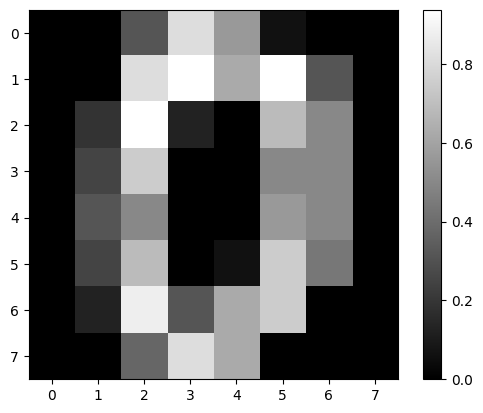

In [100]:
# Option 1: Use the entire sklearn-digits dataset:

from sklearn.datasets import load_digits
digits = load_digits()

# Target variable: One-hot-encoding: map each number of the interval [0,9] to a vector
# 9 zeros and a one, such that, e.g., 2 is mapped to [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Y = digits.target
Y = np.eye(10, dtype=int)[Y]

# Scale the feature value range to [0, 1]
X = digits.data / 16

# show an example:
im = plt.imshow(X[0].reshape(8,8), cmap='gray')
plt.colorbar(im)

# do the usual train-test split:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, fraction=0.7, seed=None)

print("shape of X_train:", X_train.shape)
print("shape of Y_train:", Y_train.shape)

shape of X_train: (879, 64)
shape of Y_train: (879, 10)


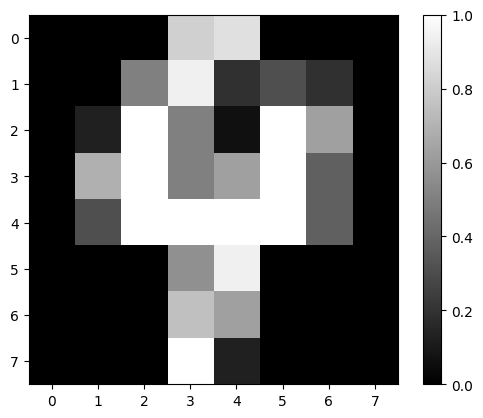

In [101]:
# Option 2: Use the MDS-Data dataset which is a larger dataset
from mdsdata import DS2_light
digits = DS2_light.load_data()

# Scale the feature value range to [0, 1]
X = digits.data / digits.data.max() 

# for training each image should be "flattened" into a "vector" of 64 elements
X = X.reshape(X.shape[0], -1)  

# Target variable: One-hot-encoding: map each number of the interval [0,9] to a vector
# 9 zeros and a one, such that, e.g., 2 is mapped to [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Y = digits.target
Y = np.eye(10, dtype=int)[Y]

# shuffle all images -- just because we will take the first few images only
# and want to be sure that they are not sorted in some way (they aren't, but
# better safe than sorry...)
n_images = 1257  # that's also the number of images in the scikit-learn dataset...  
indices = np.arange(X.shape[0])
np.random.shuffle(indices) 
indices = indices[:n_images]
X = X[indices]
Y = Y[indices]

# show an example:
im = plt.imshow(X[0].reshape(8,8), cmap='gray')
plt.colorbar(im)

# do the usual train-test split:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, fraction=0.7)

print("shape of X_train:", X_train.shape)
print("shape of Y_train:", Y_train.shape)

Assemble the network: We chose an architecture consisting of as many
input nodes as there are features which is why in the code we use `X_train.shape[-1]` .

In [102]:
nn = Network(MSE, dMSE_dy)
nn.add_layer(FullyConnectedLayer(X_train.shape[-1], 80))
nn.add_layer(ActivationLayer())
nn.add_layer(FullyConnectedLayer(80, 40))
nn.add_layer(ActivationLayer())
nn.add_layer(FullyConnectedLayer(40, 10))
nn.add_layer(ActivationLayer())

# Note that this might take up to a minute ...
train_mse = nn.train(X_train, Y_train, epochs=200, learning_rate=0.01)
train_mse[0], train_mse[-1]

(0.2443321630318221, 0.005482129345692458)

Let us now plot the mean loss for each epoch:

[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'cost (MSE)'), (0.0, 0.1)]

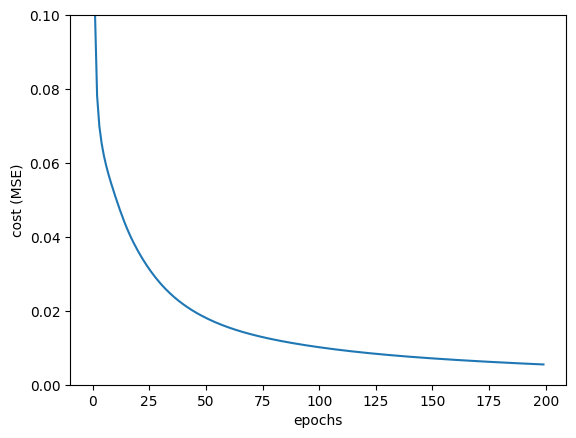

In [103]:
fig, ax = plt.subplots()
ax.plot(train_mse)
ax.set(xlabel='epochs', ylabel='cost (MSE)', ylim=(0, 0.1))

Last but not least, the confusion matrix shows information about how many images were correctly or wrongly classified as one of the digits:

In [104]:
confusion_matrix = np.zeros((10, 10), dtype=int)
Y_pred = nn.predict(X_test)

correct = 0
for yt, yp in zip(Y_test, Y_pred):
    pred_digit = np.argmax(yp)
    true_digit = np.argmax(yt)
    confusion_matrix[true_digit, pred_digit] += 1
    if true_digit == pred_digit:
        correct += 1

print(f"{correct} out of {Y_pred.size} images were correctly predicted")

361 out of 3780 images were correctly predicted


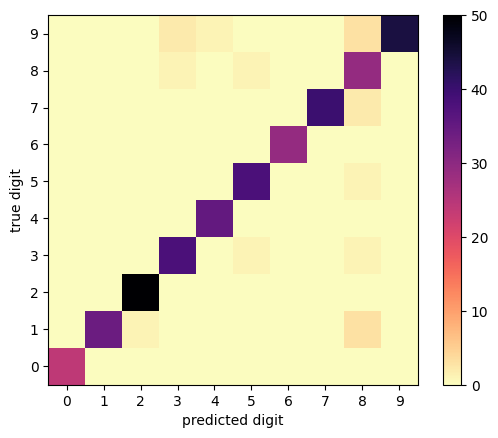

In [105]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='magma_r', origin='lower')
plt.colorbar(im)
ax.set(xlabel='predicted digit', ylabel='true digit', xticks=range(10), yticks=range(10));